In [2]:
%matplotlib inline
import numpy as np
import torch 
import torch.optim as optim


In [21]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) 
t_u = torch.tensor(t_u).unsqueeze(1)
t_u.shape

torch.Size([11, 1])

In [4]:
n_samples = t_u.shape[0]
n_samples


11

In [5]:
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
train_indices, val_indices

(tensor([ 3,  5,  9,  2,  4,  0,  8, 10,  7]), tensor([6, 1]))

In [6]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]
t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]
t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val
t_un_train.shape, t_c_train.shape

(torch.Size([9, 1]), torch.Size([9, 1]))

In [7]:
import torch.nn as nn

linear_model = nn.Linear(1,1)


In [8]:
optimizer = optim.SGD(
    linear_model.parameters(),
    lr= 1e-2
)

In [9]:
linear_model.parameters()

<generator object Module.parameters at 0x000002C6AC6AFA70>

In [10]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.0948]], requires_grad=True),
 Parameter containing:
 tensor([-0.5491], requires_grad=True)]

In [11]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1_000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f}\
                  Validation loss {loss_val.item():.4f}")

In [12]:
training_loop(
    n_epochs = 3_000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val 
)


Epoch 1, Training loss 233.3550                  Validation loss 121.1811
Epoch 1000, Training loss 3.6579                  Validation loss 2.0986
Epoch 2000, Training loss 2.7213                  Validation loss 4.5090
Epoch 3000, Training loss 2.6909                  Validation loss 5.0821


In [13]:
seq_model = nn.Sequential(nn.Linear(1, 13), nn.Tanh(), nn.Linear(13, 1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [14]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [15]:
from collections import OrderedDict

In [16]:
seq_model = nn.Sequential(OrderedDict([
    ("hidden_linear", nn.Linear(1, 8)),
    ("hidden_activation", nn.Tanh()),
    ("output_layer", nn.Linear(8, 1))
]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_layer): Linear(in_features=8, out_features=1, bias=True)
)

In [17]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_layer.weight torch.Size([1, 8])
output_layer.bias torch.Size([1])


In [18]:
optimizer = optim.SGD(seq_model.parameters(), lr = 1e-3)

training_loop(
    n_epochs = 5_000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val 
)

print(f"output {seq_model(t_un_val)}\n\
      answer {t_c_val}\n\
        hidden {seq_model.hidden_linear.weight.grad}")

Epoch 1, Training loss 216.9153                  Validation loss 111.2568


Epoch 1000, Training loss 4.8389                  Validation loss 12.5819
Epoch 2000, Training loss 2.9789                  Validation loss 13.2693
Epoch 3000, Training loss 1.4043                  Validation loss 10.1597
Epoch 4000, Training loss 1.0473                  Validation loss 8.7368
Epoch 5000, Training loss 0.9774                  Validation loss 7.9957
output tensor([[-0.0270],
        [11.4626]], grad_fn=<AddmmBackward0>)
      answer tensor([[ 3.],
        [14.]])
        hidden tensor([[ 0.0873],
        [ 0.3699],
        [ 0.9294],
        [-0.9650],
        [-0.0548],
        [ 0.0783],
        [ 0.9552],
        [-0.0729]])


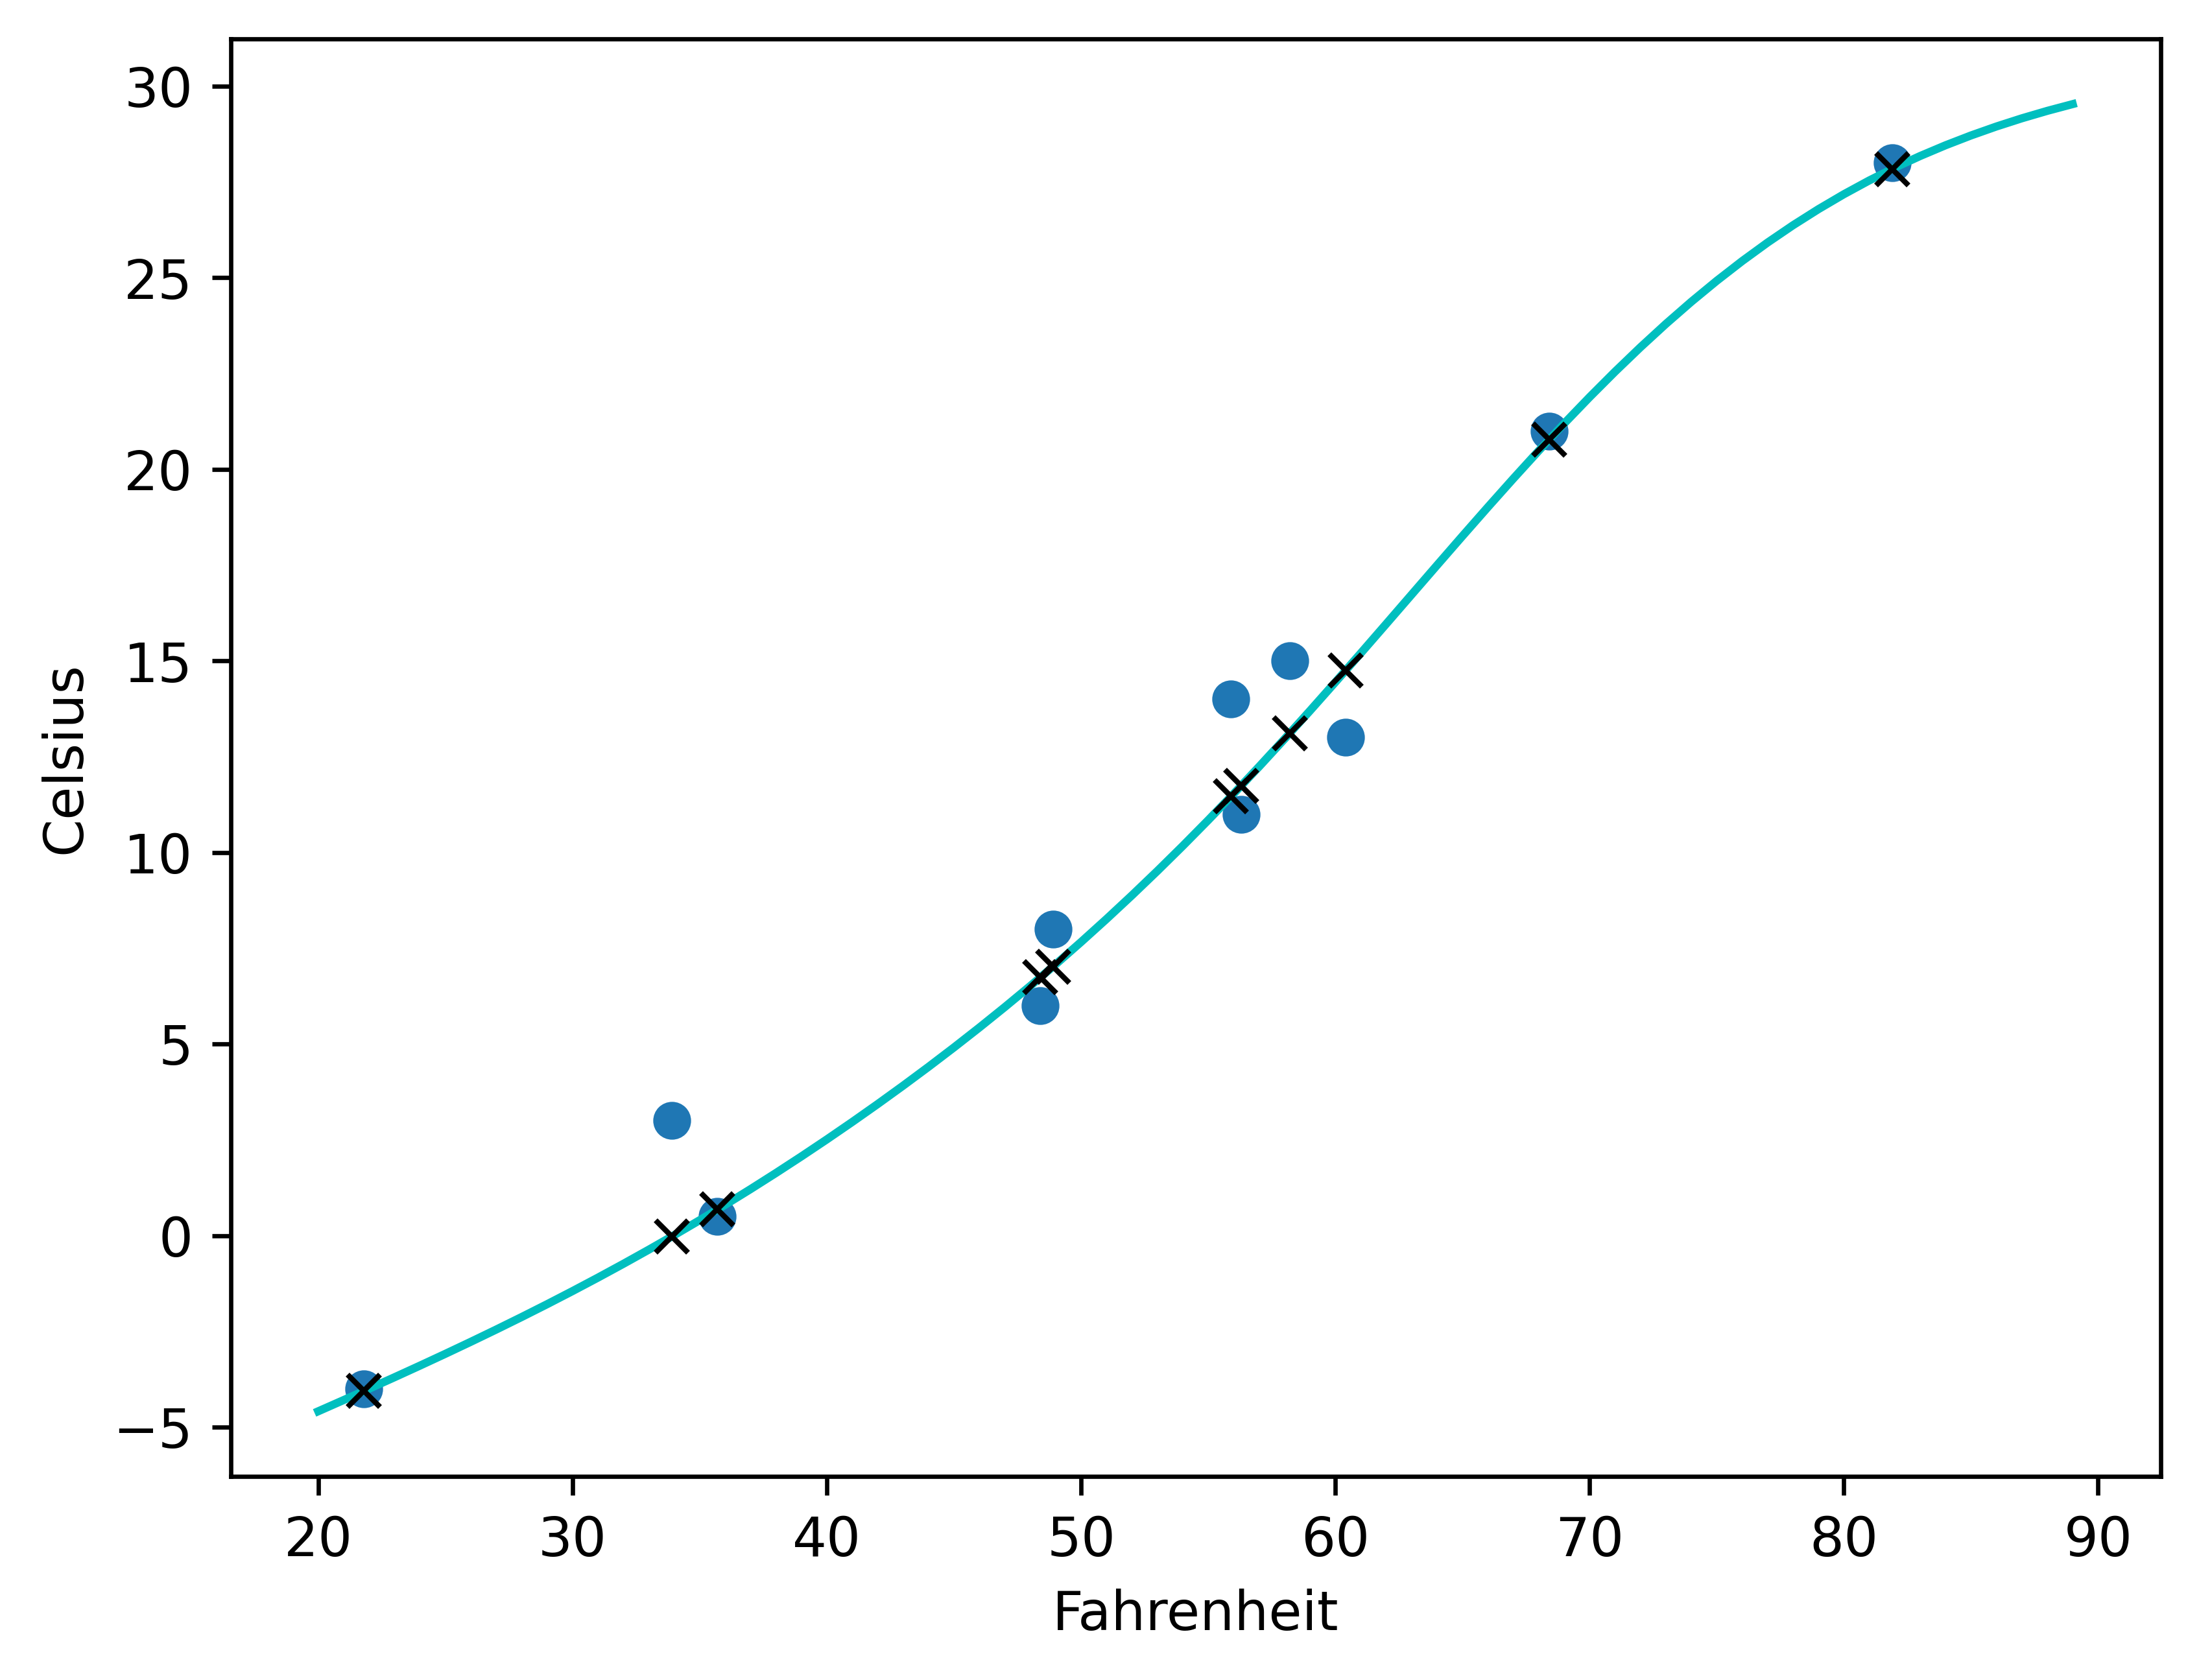

In [19]:
from matplotlib import pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
